In [1]:
import numpy as np
import h5py
import time
import json
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.v2 as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
)
import torch.nn.functional as F

torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
x_train_path = "/kaggle/input/pcam-dataset/camelyonpatch_level_2_split_train_x.h5"
y_train_path = "/kaggle/input/pcam-dataset/camelyonpatch_level_2_split_train_y.h5"

x_valid_path = "/kaggle/input/pcam-dataset/camelyonpatch_level_2_split_valid_x.h5"
y_valid_path = "/kaggle/input/pcam-dataset/camelyonpatch_level_2_split_valid_y.h5"

x_test_path = "/kaggle/input/pcam-dataset/camelyonpatch_level_2_split_test_x.h5"
y_test_path = "/kaggle/input/pcam-dataset/camelyonpatch_level_2_split_test_y.h5"

In [3]:
class PCamDataset(Dataset):
    def __init__(self, x_path, y_path, transform):
        self.transform = transform

        with h5py.File(x_path, "r") as file_x, h5py.File(y_path, "r") as file_y:
            self.images = file_x["x"][:]
            self.labels = file_y["y"][:]

        self.length = len(self.images)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        img = self.images[index]
        label = self.labels[index]

        img = self.transform(img)
        label = torch.tensor(label, dtype=torch.float32).squeeze()

        return img, label

In [4]:
def compute_metrics(labels, preds, probs):
    labels = np.array(labels)
    preds = np.array(preds)
    probs = np.array(probs)

    accuracy = 100 * accuracy_score(labels, preds)

    if np.sum(preds) == 0:
        precision = 0.0
        recall = 0.0
        f1 = 0.0
    else:
        precision = precision_score(labels, preds, average="binary")
        recall = recall_score(labels, preds, average="binary")
        f1 = f1_score(labels, preds, average="binary")

    if np.sum(labels) == 0 or np.sum(preds) == 0:
        roc_auc = 0.0
        pr_auc = 0.0
    else:
        roc_auc = roc_auc_score(labels, probs)
        pr_auc = average_precision_score(labels, probs)

    return {
        "accuracies": accuracy,
        "precisions": precision,
        "recalls": recall,
        "f1s": f1,
        "rocs": roc_auc,
        "prs": pr_auc,
    }


def round_metrics(metrics, decimals=4):
    def round_value(value):
        if isinstance(value, float):
            return round(value, decimals)
        elif isinstance(value, list):
            return [round_value(v) for v in value]
        elif isinstance(value, tuple):
            return tuple(round_value(v) for v in value)
        elif isinstance(value, dict):
            return {k: round_value(v) for k, v in value.items()}
        return value

    return {key: round_value(values) for key, values in metrics.items()}

In [5]:
def plot_metrics(epochs_range, train_vals, val_vals, ylabel, title):
    plt.plot(epochs_range, train_vals, label="Train")
    plt.plot(epochs_range, val_vals, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid()

In [6]:
def test_model(model, test_loader):
    running_test_loss = 0.0
    test_preds, test_labels, test_probs = [], [], []

    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc=f"Testing", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).squeeze(dim=1)
            loss = criterion(outputs, labels)

            running_test_loss += loss.item()
            probs = torch.sigmoid(outputs)
            predicted = (probs > 0.5).long()

            test_preds.extend(predicted.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())
            test_probs.extend(probs.detach().cpu().numpy())

    running_test_loss /= len(test_loader)
    test_metrics = compute_metrics(test_labels, test_preds, test_probs)

    print(
        f"Test Loss: {running_test_loss:.4f}, "
        f"Acc: {test_metrics['accuracies']:.4f}%, "
        f"F1: {test_metrics['f1s']:.4f}\n"
    )

    return test_metrics

In [7]:
def train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, epochs
):
    metrics = {
        "losses": ([], []),
        "accuracies": ([], []),
        "precisions": ([], []),
        "recalls": ([], []),
        "f1s": ([], []),
        "rocs": ([], []),
        "prs": ([], []),
    }

    test_metrics = {}
    best_test_accuracy = 0.0

    total_train_time, total_val_time = 0, 0

    for epoch in range(1, epochs + 1):
        model.train()
        start_time = time.time()
        running_train_loss = 0.0
        train_preds, train_labels, train_probs = [], [], []

        for images, labels in tqdm(
            train_loader, desc=f"Epoch {epoch}/{epochs} - Training", leave=False
        ):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images).squeeze(dim=1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
            probs = torch.sigmoid(outputs)
            predicted = (probs > 0.5).long()

            train_preds.extend(predicted.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
            train_probs.extend(probs.detach().cpu().numpy())

        total_train_time += time.time() - start_time
        train_metrics = compute_metrics(train_labels, train_preds, train_probs)

        if scheduler is not None:
            scheduler.step()

        model.eval()
        with torch.no_grad():
            start_time = time.time()
            running_val_loss = 0.0
            val_preds, val_labels, val_probs = [], [], []

            for images, labels in tqdm(
                val_loader, desc=f"Epoch {epoch}/{epochs} - Validation", leave=False
            ):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images).squeeze(dim=1)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item()
                probs = torch.sigmoid(outputs)
                predicted = (probs > 0.5).long()

                val_preds.extend(predicted.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
                val_probs.extend(probs.detach().cpu().numpy())

            total_val_time += time.time() - start_time
            val_metrics = compute_metrics(val_labels, val_preds, val_probs)

        running_train_loss /= len(train_loader)
        running_val_loss /= len(val_loader)

        metrics["losses"][0].append(running_train_loss)
        metrics["losses"][1].append(running_val_loss)

        for key in metrics.keys():
            if key != "losses":
                metrics[key][0].append(train_metrics[key])
                metrics[key][1].append(val_metrics[key])

        print(
            f"Epoch [{epoch}/{epochs}]:\n"
            f"Train Loss: {metrics['losses'][0][-1]:.4f}, "
            f"Acc: {metrics['accuracies'][0][-1]:.4f}%, "
            f"F1: {metrics['f1s'][0][-1]:.4f}\n"
            f"Val Loss: {metrics['losses'][1][-1]:.4f}, "
            f"Acc: {metrics['accuracies'][1][-1]:.4f}%, "
            f"F1: {metrics['f1s'][1][-1]:.4f}\n"
        )

        if epoch == 10 or epoch == 15 or epoch == 25:
            checkpoint = {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "scheduler_state_dict": (
                    scheduler.state_dict() if scheduler is not None else None
                ),
            }
            torch.save(checkpoint, f"model_{epoch}.pth")

        test_met = test_model(model, test_loader)
        test_metrics[f"Testing_{epoch}"] = test_met

        test_accuracy = test_met["accuracies"]

        if epoch == 10 or epoch == 15 or epoch == 25:
            print(f"Test Accuracy at epoch: {epoch} is {test_accuracy} %\n")
            
        if test_accuracy >= best_test_accuracy:
            best_test_accuracy = test_accuracy
            print(f"Best Model saving at epoch: {epoch} with accuracy: {test_accuracy} %\n")
            checkpoint = {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "scheduler_state_dict": (
                    scheduler.state_dict() if scheduler is not None else None
                ),
            }
            torch.save(checkpoint, f"model_best.pth")

    total_train_time /= 60
    total_val_time /= 60

    print(f"Best test accuracy: {best_test_accuracy} %\n")
    print(
        f"Total Training Time: {(total_train_time):.2f} min, Validation Time: {(total_val_time):.2f} min"
    )

    metrics["total_times"] = {
        "training_time (mins)": total_train_time,
        "validation_time (mins)": total_val_time,
    }
    metrics["Testing"] = test_metrics

    return metrics

In [8]:
train_transform = transforms.Compose(
    [
        transforms.ToImage(),
        transforms.RandomResizedCrop(size=(96, 96), scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToDtype(torch.float32, scale=True),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

test_transform = transforms.Compose(
    [
        transforms.ToImage(),
        transforms.Resize((96, 96)),
        transforms.ToDtype(torch.float32, scale=True),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)


train_dataset = PCamDataset(x_train_path, y_train_path, transform=train_transform)
val_dataset = PCamDataset(x_valid_path, y_valid_path, transform=test_transform)
test_dataset = PCamDataset(x_test_path, y_test_path, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True, persistent_workers=True)

In [9]:
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=1):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding, groups=in_channels, bias=False)
        self.pointwise = nn.Conv2d(in_channels, out_channels, 1, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.bn(x)
        return self.relu(x)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False):
        super(ResidualBlock, self).__init__()
        stride = 2 if downsample else 1
        self.conv = DepthwiseSeparableConv(in_channels, out_channels, kernel_size=3, stride=stride)
        self.shortcut = (
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False) 
            if in_channels != out_channels or downsample else nn.Identity()
        )
    
    def forward(self, x):
        return self.conv(x) + self.shortcut(x)

class InceptionModule(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(InceptionModule, self).__init__()
        self.conv1x1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0, bias=False)
        self.conv3x3 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.conv5x5 = nn.Conv2d(in_channels, out_channels, kernel_size=5, padding=2, bias=False)
    
    def forward(self, x):
        x1 = self.conv1x1(x)
        x2 = self.conv3x3(x)
        x3 = self.conv5x5(x)
        return torch.cat([x1, x2, x3], dim=1)

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.init_conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.res_block1 = ResidualBlock(64, 64)
        self.res_block2 = ResidualBlock(64, 128, downsample=True) 
        self.res_block3 = ResidualBlock(128, 256, downsample=True) 
        self.inception = InceptionModule(256, 256)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((6,6))
        self.fc = nn.Sequential(
            nn.Linear(256 * 3 * 6 * 6, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
        )
    
    def forward(self, x):
        x = self.init_conv(x)        
        x = self.res_block1(x)        
        x = self.res_block2(x)        
        x = self.res_block3(x)        
        x = self.inception(x)        
        x = self.global_avg_pool(x)        
        x = torch.flatten(x, 1)        
        x = self.fc(x)
        
        return x


In [10]:
model = CustomCNN()
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = None

epochs = 25

print(model)

CustomCNN(
  (init_conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (res_block1): ResidualBlock(
    (conv): DepthwiseSeparableConv(
      (depthwise): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
      (pointwise): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (shortcut): Identity()
  )
  (res_block2): ResidualBlock(
    (conv): DepthwiseSeparableConv(
      (depthwise): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64, bias=False)
      (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu

Epoch [1/25]:
Train Loss: 0.4684, Acc: 78.4199%, F1: 0.7864
Val Loss: 0.4523, Acc: 79.3365%, F1: 0.7835



Test Loss: 0.4633, Acc: 77.6917%, F1: 0.7597

Best Model saving at epoch: 1 with accuracy: 77.691650390625 %



Epoch [2/25]:
Train Loss: 0.4126, Acc: 81.6765%, F1: 0.8167
Val Loss: 0.3960, Acc: 82.2205%, F1: 0.8188



Test Loss: 0.4157, Acc: 81.0974%, F1: 0.8034

Best Model saving at epoch: 2 with accuracy: 81.097412109375 %



Epoch [3/25]:
Train Loss: 0.3773, Acc: 83.5106%, F1: 0.8343
Val Loss: 0.4853, Acc: 76.8188%, F1: 0.7269



Test Loss: 0.5633, Acc: 71.6309%, F1: 0.6409



Epoch [4/25]:
Train Loss: 0.3510, Acc: 84.8469%, F1: 0.8474
Val Loss: 0.3627, Acc: 83.4717%, F1: 0.8213



Test Loss: 0.4631, Acc: 78.9917%, F1: 0.7570



Epoch [5/25]:
Train Loss: 0.3325, Acc: 85.8559%, F1: 0.8573
Val Loss: 0.3760, Acc: 84.0027%, F1: 0.8325



Test Loss: 0.4131, Acc: 80.7068%, F1: 0.7876



Epoch [6/25]:
Train Loss: 0.3198, Acc: 86.4971%, F1: 0.8637
Val Loss: 0.3724, Acc: 82.5562%, F1: 0.8040



Test Loss: 0.4569, Acc: 78.9581%, F1: 0.7499



Epoch [7/25]:
Train Loss: 0.3089, Acc: 87.0846%, F1: 0.8695
Val Loss: 0.3395, Acc: 85.0739%, F1: 0.8406



Test Loss: 0.4335, Acc: 80.3284%, F1: 0.7754



Epoch [8/25]:
Train Loss: 0.3004, Acc: 87.5313%, F1: 0.8741
Val Loss: 0.3812, Acc: 84.7717%, F1: 0.8351



Test Loss: 0.4291, Acc: 80.8105%, F1: 0.7802



Epoch [9/25]:
Train Loss: 0.2943, Acc: 87.8971%, F1: 0.8776
Val Loss: 0.3561, Acc: 85.0647%, F1: 0.8381



Test Loss: 0.4205, Acc: 80.9174%, F1: 0.7826



Epoch [10/25]:
Train Loss: 0.2866, Acc: 88.1920%, F1: 0.8806
Val Loss: 0.3227, Acc: 86.3708%, F1: 0.8618



Test Loss: 0.4003, Acc: 82.7118%, F1: 0.8142

Test Accuracy at epoch: 10 is 82.7117919921875 %

Best Model saving at epoch: 10 with accuracy: 82.7117919921875 %



Epoch [11/25]:
Train Loss: 0.2836, Acc: 88.4045%, F1: 0.8828
Val Loss: 0.3260, Acc: 86.2274%, F1: 0.8560



Test Loss: 0.3671, Acc: 83.5510%, F1: 0.8203

Best Model saving at epoch: 11 with accuracy: 83.551025390625 %



Epoch [12/25]:
Train Loss: 0.2769, Acc: 88.7367%, F1: 0.8860
Val Loss: 0.3862, Acc: 84.0698%, F1: 0.8194



Test Loss: 0.5136, Acc: 77.9297%, F1: 0.7274



Epoch [13/25]:
Train Loss: 0.2722, Acc: 88.9183%, F1: 0.8879
Val Loss: 0.3675, Acc: 84.3018%, F1: 0.8326



Test Loss: 0.3920, Acc: 82.4310%, F1: 0.8057



Epoch [14/25]:
Train Loss: 0.2700, Acc: 89.0415%, F1: 0.8890
Val Loss: 0.3567, Acc: 85.8734%, F1: 0.8467



Test Loss: 0.4280, Acc: 82.2357%, F1: 0.7962



Epoch [15/25]:
Train Loss: 0.2655, Acc: 89.2353%, F1: 0.8910
Val Loss: 0.3153, Acc: 87.4146%, F1: 0.8691



Test Loss: 0.3508, Acc: 84.6252%, F1: 0.8329

Test Accuracy at epoch: 15 is 84.625244140625 %

Best Model saving at epoch: 15 with accuracy: 84.625244140625 %



Epoch [16/25]:
Train Loss: 0.2609, Acc: 89.4493%, F1: 0.8932
Val Loss: 0.3316, Acc: 86.4594%, F1: 0.8615



Test Loss: 0.3814, Acc: 84.6497%, F1: 0.8370

Best Model saving at epoch: 16 with accuracy: 84.649658203125 %



Epoch [17/25]:
Train Loss: 0.2599, Acc: 89.4917%, F1: 0.8937
Val Loss: 0.3194, Acc: 86.6730%, F1: 0.8600



Test Loss: 0.3616, Acc: 84.6436%, F1: 0.8319



Epoch [18/25]:
Train Loss: 0.2563, Acc: 89.6835%, F1: 0.8955
Val Loss: 0.3353, Acc: 86.3922%, F1: 0.8642



Test Loss: 0.3264, Acc: 85.8093%, F1: 0.8550

Best Model saving at epoch: 18 with accuracy: 85.809326171875 %



Epoch [19/25]:
Train Loss: 0.2528, Acc: 89.8705%, F1: 0.8975
Val Loss: 0.4525, Acc: 83.7799%, F1: 0.8165



Test Loss: 0.4868, Acc: 79.9744%, F1: 0.7613



Epoch [20/25]:
Train Loss: 0.2488, Acc: 89.9929%, F1: 0.8987
Val Loss: 0.3938, Acc: 85.9467%, F1: 0.8498



Test Loss: 0.3832, Acc: 83.5632%, F1: 0.8169



Epoch [21/25]:
Train Loss: 0.2477, Acc: 90.1173%, F1: 0.8999
Val Loss: 0.3288, Acc: 87.6678%, F1: 0.8709



Test Loss: 0.3267, Acc: 86.1816%, F1: 0.8500

Best Model saving at epoch: 21 with accuracy: 86.181640625 %



Epoch [22/25]:
Train Loss: 0.2464, Acc: 90.1737%, F1: 0.9005
Val Loss: 0.3243, Acc: 86.8622%, F1: 0.8625



Test Loss: 0.3782, Acc: 84.5978%, F1: 0.8320



Epoch [23/25]:
Train Loss: 0.2433, Acc: 90.2538%, F1: 0.9013
Val Loss: 0.3710, Acc: 85.7361%, F1: 0.8443



Test Loss: 0.3691, Acc: 83.7158%, F1: 0.8161



Epoch [24/25]:
Train Loss: 0.2418, Acc: 90.3210%, F1: 0.9020
Val Loss: 0.3248, Acc: 86.6730%, F1: 0.8629



Test Loss: 0.3447, Acc: 84.7107%, F1: 0.8365



Epoch [25/25]:
Train Loss: 0.2394, Acc: 90.4873%, F1: 0.9036
Val Loss: 0.3681, Acc: 86.2000%, F1: 0.8520



Test Loss: 0.3740, Acc: 83.6456%, F1: 0.8171

Test Accuracy at epoch: 25 is 83.6456298828125 %

Best test accuracy: 86.181640625 %

Total Training Time: 173.25 min, Validation Time: 4.81 min


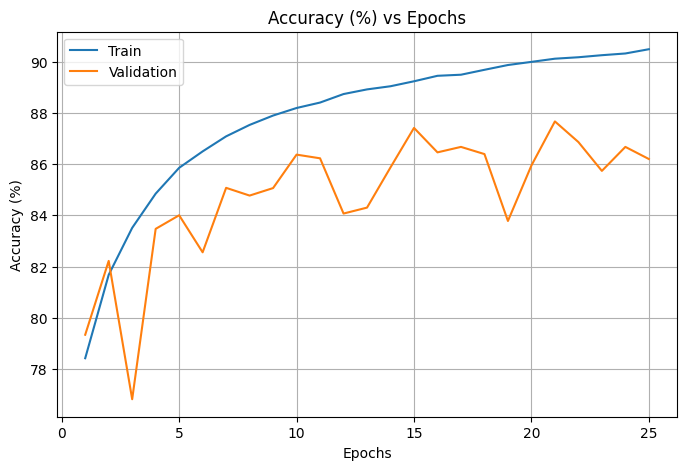

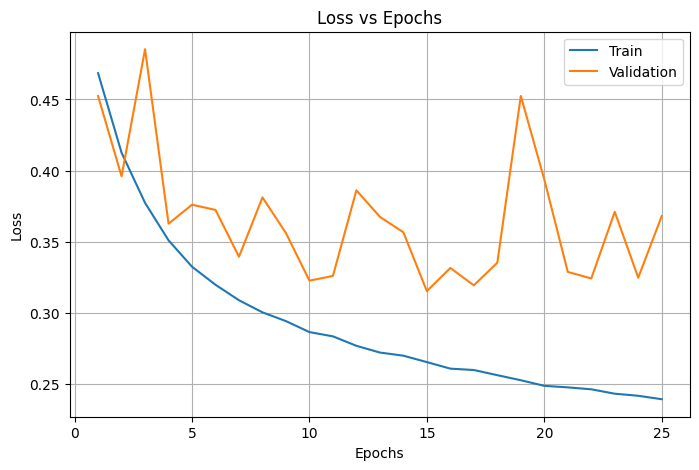

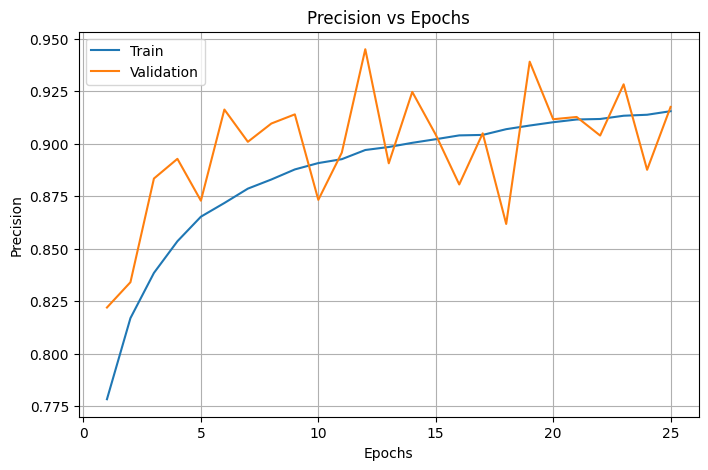

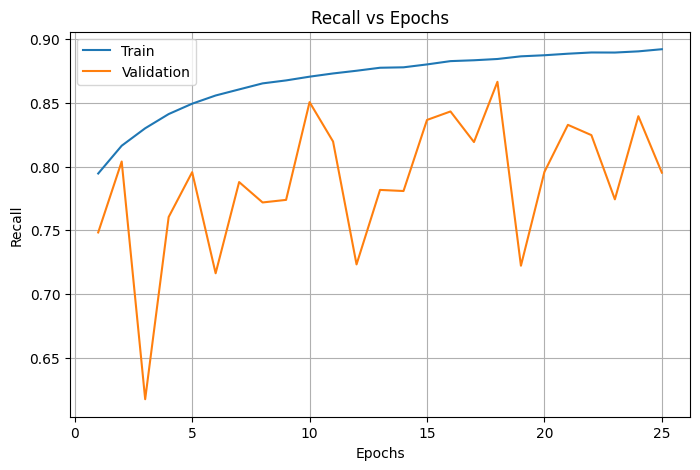

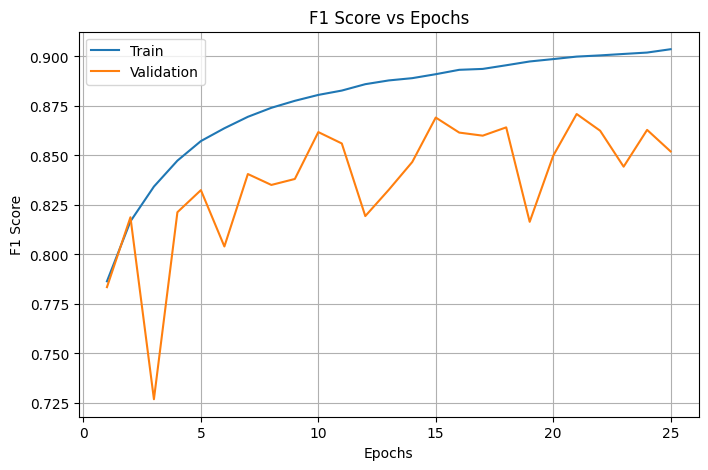

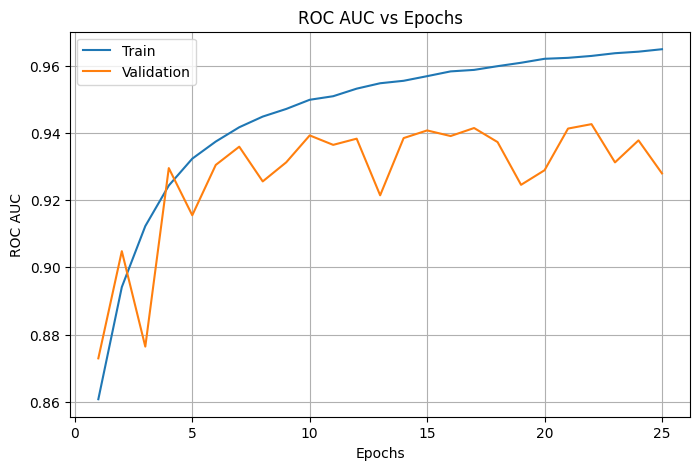

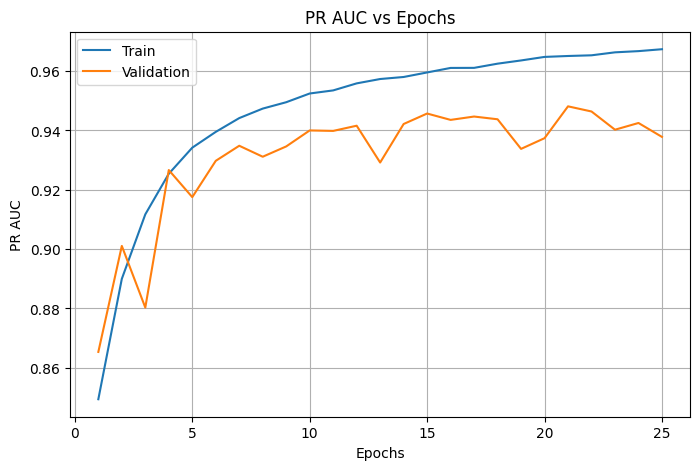

In [11]:
train_metrics = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, epochs
)

with open("metrics.json", "w") as f:
    json.dump(round_metrics(train_metrics), f, indent=4)

epochs_range = range(1, epochs + 1)

metric_names = [
    "accuracies",
    "losses",
    "precisions",
    "recalls",
    "f1s",
    "rocs",
    "prs",
]
metric_labels = [
    "Accuracy (%)",
    "Loss",
    "Precision",
    "Recall",
    "F1 Score",
    "ROC AUC",
    "PR AUC",
]

for metric, label in zip(metric_names, metric_labels):
    plt.figure(figsize=(8, 5))
    plot_metrics(epochs_range, *train_metrics[metric], label, f"{label} vs Epochs")
    plt.savefig(f"{metric}.png", bbox_inches="tight")
    plt.show()
    plt.close()